In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from tqdm import tqdm

import scanpy as sc

from causarray import *

# BH statistics

In [30]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from tqdm import tqdm

from causarray import *
from generate_simu_data import generate_data


n_list = [100, 200, 300, 400, 500]
p_list = [8000]
signal_list = [1.]
noise_sigma_0_list = [0.0, 0.05, 0.1]

m = 100
ps = 200
d = 5

c = 0.1
alpha = 0.05
q_alpha = 0.1
signal = 1.
noise_sigma_0 = 0
noise_ratio = 0 if noise_sigma_0 == 0. else 0.05

shift = 'mean'
signal = 1.

K = int(1)


seed= 0
n=100
p=8000
W, A, X, Y, theta, _ = generate_data(
    n, p, d-1, m, ps, intercept=1.,
    shift=shift, psi=0.,
    scale_beta=0.5 if shift=='median' else 2.,
    signal=signal, seed=seed)
X = np.transpose(X, (1,0,2))
Yg = np.sum(X, 1)

func = ATE
df = func(Yg.copy(), W.copy(), A.copy(), B=1000, alpha=alpha, c=c, family='poisson', K=K)

pred = (df['qvals'] <= q_alpha).astype(int)
res = comp_stat(true, pred, c)
res.insert(0, func.__name__ + '-BH')

print('num of non-nulls: {}, num of discoveries by BH: {}, false discovery rate by BH: {}'.format(
    np.sum(theta!=0), res[-1], res[2]))

num of non-nulls: 200, num of discoveries by BH: 258, false discovery rate by BH: 0.3062015503875969


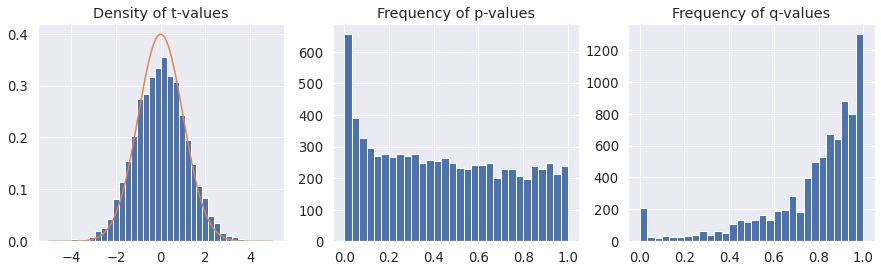

In [27]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,3, figsize=(15,4))

x_axis = np.arange(-5, 5, 0.001)
axes[0].hist(df['tvalues_init'], bins=30, density=True, range=[-4,4])
axes[0].plot(x_axis, sp.stats.norm.pdf(x_axis,0,1))
axes[0].set_title('Density of t-values')

axes[1].hist(df['pvals'], bins=30)
axes[1].set_title('Frequency of p-values')

axes[2].hist(df['qvals'], bins=30)
axes[2].set_title('Frequency of q-values')

plt.savefig('figures/BH-stat.pdf', bbox_inches='tight', pad_inches=0, dpi=300)


# Results without sample splitting

In [2]:
path_result = 'results/simu/'

K = 1
n_list = [100, 200, 300, 400]
p_list = [8000]
signal_list = [1.,10.]

shift_list = ['mean', 'median']
signal = signal_list[0]
noise_sigma_1_list = [0, 0.05]


df_res = pd.DataFrame()
for signal,shift in zip(signal_list,shift_list):
    for n in n_list:
        for p in p_list:
            df = pd.DataFrame()
            for seed in range(50):
                try:
                    _df = pd.read_csv(path_result+'n_{}_p_{}_signal_{:.02f}_shift_{}_K_{}_seed_{}.csv'.format(n,p,signal,shift,K,seed))
                    df = pd.concat([df, _df], axis=0)
                except:
                    pass
            df['n'] = n
            df['p'] = p
            # df['noise'] = noise
            df['shift'] = shift
            df_res = pd.concat([df_res, df], axis=0)

df_res.reset_index(drop=True, inplace=True)
df_res['ratio'] = df_res['n']
df_res['ratio'] = df_res['ratio'].astype(str)
df_res.sort_values(by=['ratio'], inplace=True)
df_res['Estimand'] = df_res['Method'].apply(lambda x: x.replace('-BH',''))
df_res['Method'] = df_res['Method'].apply(lambda x: 'BH' if 'BH' in x else 'Proposed')

df_res = df_res.loc[~df_res['Estimand'].str.startswith('SQTE')]
df_res['Estimand'] = df_res['Estimand'].apply(lambda x: x.replace('SATE','STE'))

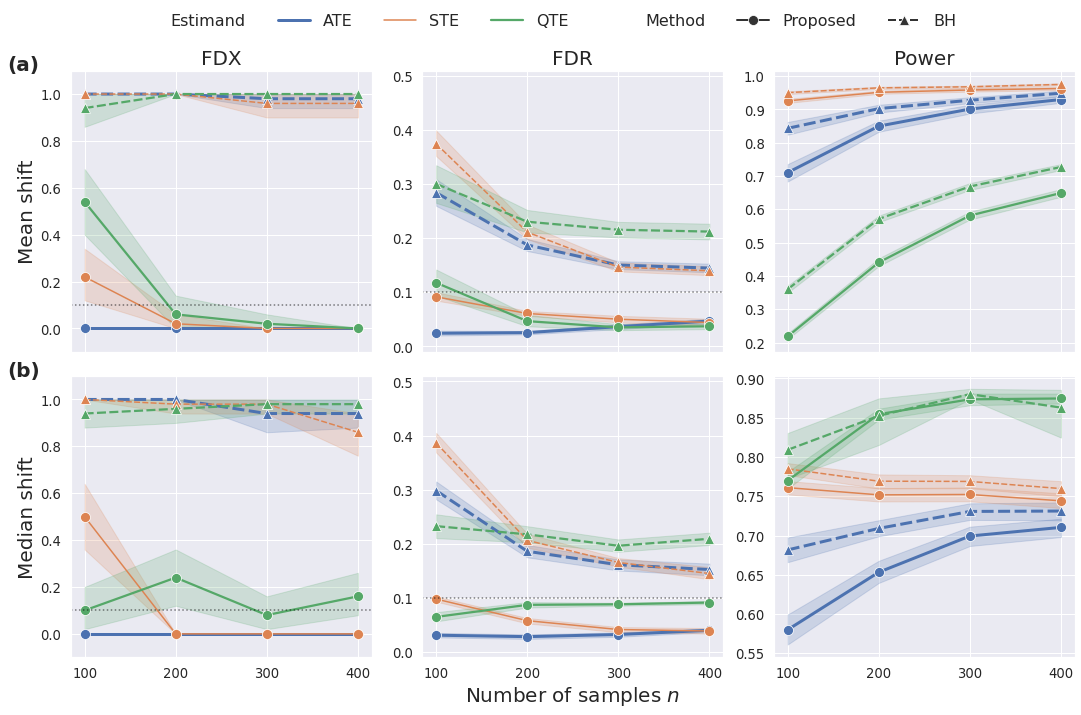

In [4]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=False)

hue_order = ['ATE', 'STE', 'QTE']
size_order = ['ATE',  'QTE', 'STE']

for j, shift in enumerate(shift_list):

    df = df_res[df_res['shift']==shift]
    sns.lineplot(df, x='ratio', y='FDPex', hue='Estimand', hue_order=hue_order,
        size='Estimand', size_order=size_order, sizes=(1.5, 3),
        style='Method', style_order=['Proposed', 'BH'],    
        lw=2, markers=['o','^'], markersize=10, ax=axes[j,0])
    axes[j,0].axhline(y=0.1, color='black', alpha=0.5, linestyle=':')

    sns.lineplot(df, x='ratio', y='FDP', hue='Estimand', hue_order=hue_order,
        size='Estimand', size_order=size_order, sizes=(1.5, 3),
        style='Method', style_order=['Proposed', 'BH'], 
        lw=2, markers=['o','^'], markersize=10, ax=axes[j,1])
    axes[j,1].axhline(y=0.1, color='black', alpha=0.5, linestyle=':')

    sns.lineplot(df, x='ratio', y='power', hue='Estimand', hue_order=hue_order,
        size='Estimand', size_order=size_order, sizes=(1.5, 3),
        style='Method', style_order=['Proposed', 'BH'],
        lw=2, markers=['o','^'], markersize=10, ax=axes[j,2])


ylabels = ['FDX', 'FDR', 'Power']
for j in range(3):
    if j==1:
        axes[1,j].set_xlabel('Number of samples $n$', fontsize=20)
    else:
        axes[1,j].set_xlabel('')        
            
    axes[0,j].set_title(ylabels[j], fontsize=20)

for i in range(2):
    for j in range(1,3):
        axes[i,j].set_ylabel('')
    axes[i,0].set_ylim([-0.1,1.1])
    axes[i,1].set_ylim([-0.01,0.51])


axes[0,0].set_ylabel('Mean shift', fontsize=20)
axes[1,0].set_ylabel('Median shift', fontsize=20)
axes[0,0].text(axes[0,0].get_xlim()[0]-0.7, axes[0,0].get_ylim()[1], '(a)', fontsize=20, weight='bold')
axes[1,0].text(axes[1,0].get_xlim()[0]-0.7, axes[1,0].get_ylim()[1], '(b)', fontsize=20, weight='bold')


legend = axes[0,0].get_legend(); handles = legend.legendHandles
labels = [t.get_text() for t in legend.get_texts()]
for i in range(2):
    for j in range(3):
        axes[i,j].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=10, title=None, frameon=False, fontsize=16)
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('figures/simu_nosplit.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Results with sample splitting

In [5]:
path_result = 'results/simu/'
K = 5
n_list = [100, 200, 300, 400]
p_list = [8000]
signal_list = [1.,10.]

shift_list = ['mean', 'median']
signal = signal_list[0]
noise_sigma_1_list = [0, 0.05]


df_res = pd.DataFrame()
for signal,shift in zip(signal_list,shift_list):
    for n in n_list:
        for p in p_list:
            df = pd.DataFrame()
            for seed in range(50):
                try:
                    _df = pd.read_csv(path_result+'n_{}_p_{}_signal_{:.02f}_shift_{}_K_{}_seed_{}.csv'.format(n,p,signal,shift,K,seed))
                    df = pd.concat([df, _df], axis=0)
                except:
                    pass
            df['n'] = n
            df['p'] = p
            df['shift'] = shift
            df_res = pd.concat([df_res, df], axis=0)

df_res.reset_index(drop=True, inplace=True)
df_res['ratio'] = df_res['n']
df_res['ratio'] = df_res['ratio'].astype(str)
df_res.sort_values(by=['ratio'], inplace=True)
df_res['Estimand'] = df_res['Method'].apply(lambda x: x.replace('-BH',''))
df_res['Method'] = df_res['Method'].apply(lambda x: 'BH' if 'BH' in x else 'Proposed')

df_res = df_res.loc[~df_res['Estimand'].str.startswith('SQTE')]
df_res['Estimand'] = df_res['Estimand'].apply(lambda x: x.replace('SATE','STE'))

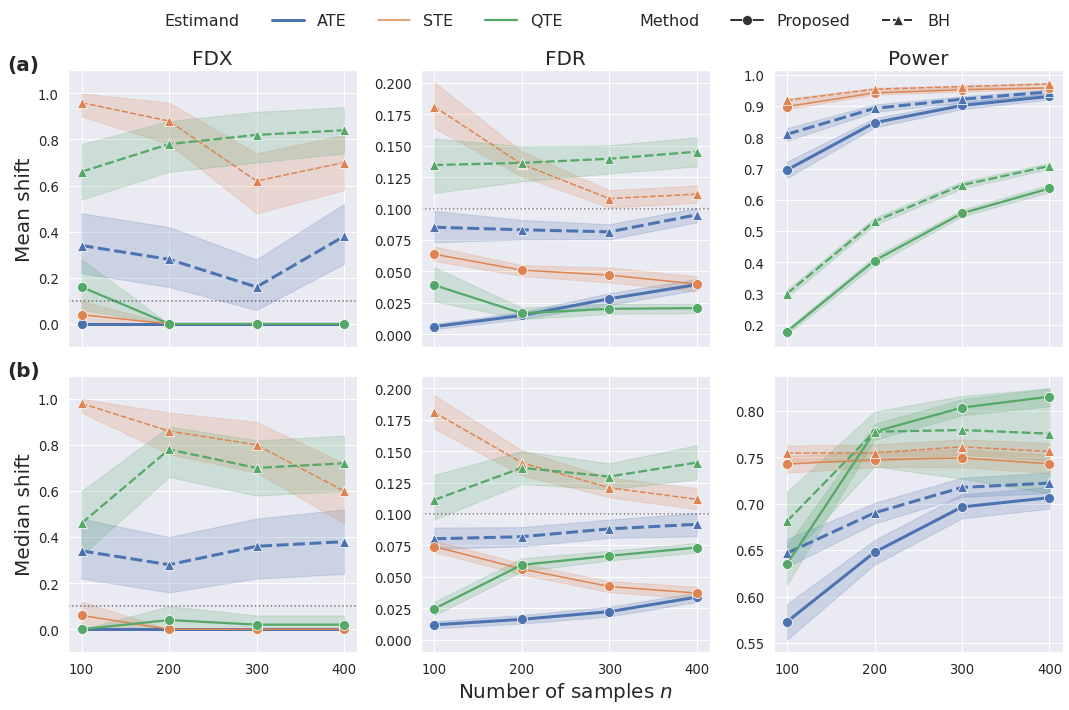

In [6]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=False)

hue_order = ['ATE', 'STE', 'QTE']
size_order = ['ATE',  'QTE', 'STE']

for j, shift in enumerate(shift_list):
    df = df_res[df_res['shift']==shift]
    sns.lineplot(df, x='ratio', y='FDPex', hue='Estimand', hue_order=hue_order,
        size='Estimand', size_order=size_order, sizes=(1.5, 3),
        style='Method', style_order=['Proposed', 'BH'],    
        lw=2, markers=['o','^'], markersize=10, ax=axes[j,0])
    axes[j,0].axhline(y=0.1, color='black', alpha=0.5, linestyle=':')

    sns.lineplot(df, x='ratio', y='FDP', hue='Estimand', hue_order=hue_order,
        size='Estimand', size_order=size_order, sizes=(1.5, 3),
        style='Method', style_order=['Proposed', 'BH'], 
        lw=2, markers=['o','^'], markersize=10, ax=axes[j,1])
    axes[j,1].axhline(y=0.1, color='black', alpha=0.5, linestyle=':')

    sns.lineplot(df, x='ratio', y='power', hue='Estimand', hue_order=hue_order,
        size='Estimand', size_order=size_order, sizes=(1.5, 3),
        style='Method', style_order=['Proposed', 'BH'],
        lw=2, markers=['o','^'], markersize=10, ax=axes[j,2])


ylabels = ['FDX', 'FDR', 'Power']
for j in range(3):
    if j==1:
        axes[1,j].set_xlabel('Number of samples $n$', fontsize=20)
    else:
        axes[1,j].set_xlabel('')        
            
    axes[0,j].set_title(ylabels[j], fontsize=20)

for i in range(2):
    for j in range(1,3):
        axes[i,j].set_ylabel('')
    axes[i,0].set_ylim([-0.1,1.1])
    axes[i,1].set_ylim([-0.01,0.21])

axes[0,0].set_ylabel('Mean shift', fontsize=20)
axes[1,0].set_ylabel('Median shift', fontsize=20)
axes[0,0].text(axes[0,0].get_xlim()[0]-0.7, axes[0,0].get_ylim()[1], '(a)', fontsize=20, weight='bold')
axes[1,0].text(axes[1,0].get_xlim()[0]-0.7, axes[1,0].get_ylim()[1], '(b)', fontsize=20, weight='bold')


legend = axes[0,0].get_legend(); handles = legend.legendHandles
labels = [t.get_text() for t in legend.get_texts()]
for i in range(2):
    for j in range(3):
        axes[i,j].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=10, title=None, frameon=False, fontsize=16)
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('figures/simu_split.pdf', bbox_inches='tight', pad_inches=0, dpi=300)